In [20]:
import sys
sys.path.append('/home/emastr/phd/projects/vahid_project/src/')
sys.path.append('/home/emastr/phd/')

from alignment_vmap import *
import numpy as np
import jax.numpy as jnp
from numpy.fft import fft, ifft
import jax
from jax import vmap, grad, jit, random, lax
from util.logger import EventTracker
import matplotlib.pyplot as plt

In [21]:
logger = EventTracker()
d = 41
N=int(1e4)
noise=1.#1.


#d = 5
#N = int(4e3)
#noise = 1/2.**0.5#1.#1.#1.

## GENERATE SIGNAL
t = np.linspace(0, 2*np.pi, d+1)[:-1]
x = (t < np.pi).astype(float)
#x = np.exp(4 * jnp.sin(t))
#x = x / np.linalg.norm(x) * np.sqrt(d)
xfft = fft(x)


In [22]:

iters = []
losses = []
xs = []


def cb(xfft, res, it):
    print(f"step {it}. res: {res}", end="\r")
    
def run_and_avg(N):
    def run_avg_func(func):
        def run_avg():
            print(f"Running {N} times")
            return jnp.mean(jnp.vstack([func() for _ in range(N)]), axis=0)
        return run_avg
    return run_avg_func

@run_and_avg(50)
def run():
    shift = np.random.randint(0, d, N)
    y = np.vstack([jnp.roll(x, s) for s in shift])
    w = np.random.randn(*y.shape) * noise
    y = y + w
    
    ## FOURIER TRANSFORM
    yfft = fft(y, axis=1)

    # Moments
    #acf_fft = jnp.clip(jnp.mean(np.abs(yfft)**2, axis=0) - noise**2 * d, 0, None)
    acf_fft = np.abs(xfft)**2
    mean = jnp.mean(yfft[:, 0])

    x0 = y[0, :].copy()
    xi = ifft(fix_point_iter(fft(x0), yfft, acf_fft, mean, alpha=1.0, tol=1e-10, maxiter=200, callback=cb)).real
    xi_al = align(fft(x), fft(xi)[None, :], xi[None, :])[0].real
    return jnp.linalg.norm(x - xi_al)/jnp.linalg.norm(x)

run()


Running 50 times


Array([0.03585596], dtype=float32)

In [1]:
# EM-amplitudes (better than ML?)
# Ours for phase
# Coupled approach? (phase + amplitude)

# Plot num iterations as function of noise / running time as function of noise
# Recreate the plots and add our method (EM + baseline)
# sigma = 1 ~ 77
# sigma = 2 ~ 71
# sigma = 4 ~ 183
# Download the code and generate the plots again.
# 1. Plot the running time as function of noise
# 2. Plot the number of iterations as function of noise
# 3. Plot the relative error as function of noise
# 4. Plot the relative error as function of number of iterations

# Comparison
# Take EM-amplitudes and compare phases to EM-phases
# EM on single modes to determine amplitude 1 by 1.

# 
# Giulia, Aurora, Björn, Vahid, Emanuel, Jonathan

# https://github.com/NicolasBoumal/MRA

# Transactions on Information Theory - Joakim thinks about journals
# 30 sec for sigma = 4 to run, d=41, N=1e4 (avg computation times / relative error)

60.0

NameError: name 'yfft' is not defined

<Figure size 1500x1000 with 0 Axes>

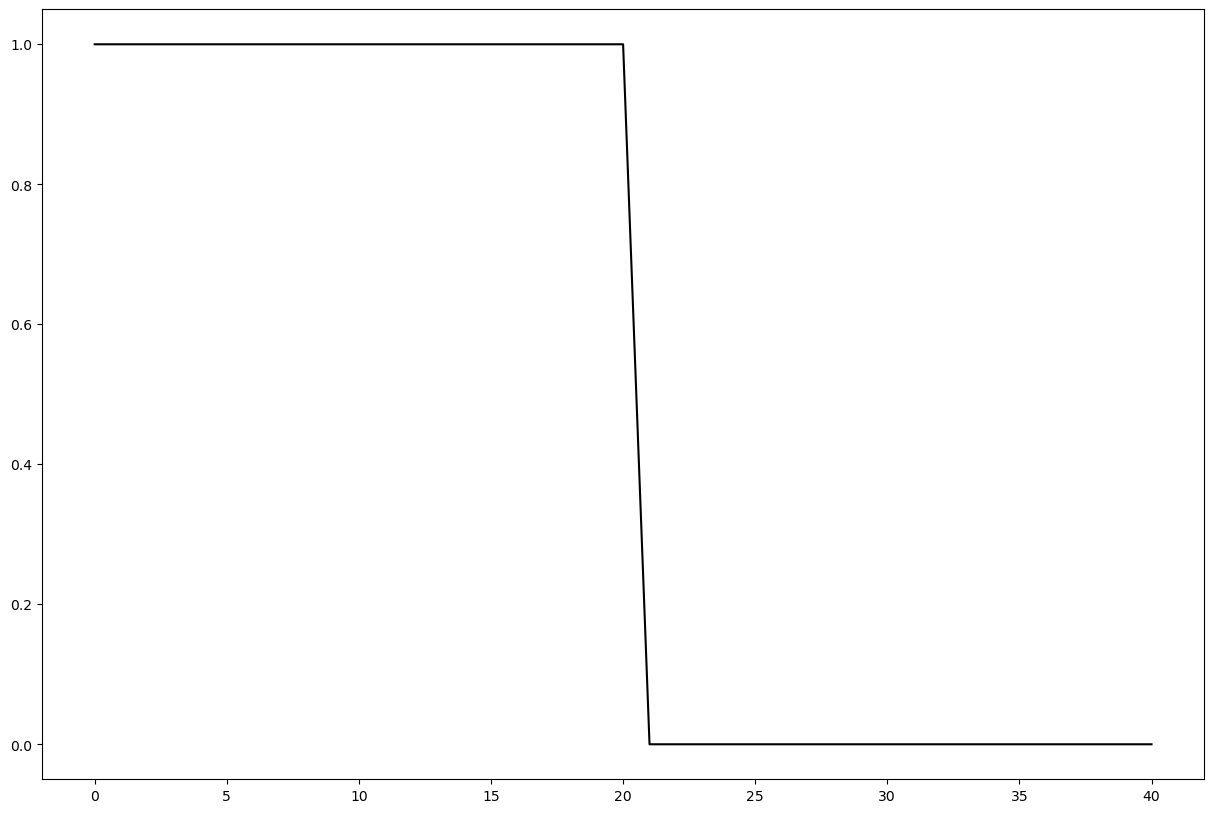

<Figure size 1500x1000 with 0 Axes>

In [24]:
#losses = [losses_fp, losses_pg, losses_pn]
names = ['SFP', 'CFP', 'FP']
linestyles = ['r-', 'b--', 'g:']

plt.figure(1, figsize=(15,10))
plt.figure(2, figsize=(15,10))
plt.plot(x, 'k', label='true')
plt.figure(3, figsize=(15,10))

for xi, li, ni, ls in zip(xs, losses, names, linestyles):
    x_al = align(fft(x), fft(xi)[None, :], xi[None, :])[0].real
    
    print(f"{ni}: {np.linalg.norm(x - x_al)/np.linalg.norm(x):.4f}, loss: {loss_fft(fft(x_al), yfft):.4f}")
    
    plt.figure(1)
    plt.plot(li, ls + '*', label=ni)    

    plt.figure(2)
    plt.plot(x_al, ls, label=ni)
    
    plt.figure(3)
    plt.plot(np.abs(x_al-x), ls, label=ni)


print(f"TRU: {np.linalg.norm(x - x)/np.linalg.norm(x):.4f}, loss: {loss_fft(fft(x), yfft):.4f}")
    
    
plt.figure(1)
plt.legend()
plt.yscale('log')

plt.figure(2)
plt.legend()
plt.ylim([min(x)-0.4, max(x)+0.4])

plt.figure(3)
plt.legend()

